In [1]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
settings.init()
from tensorflow import keras
from tensorflow.keras import layers
tf.autograph.set_verbosity(0, False)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental_run_functions_eagerly(True)

print("\nTensorflow report:")
print("Devices:", tf.config.list_physical_devices('GPU'))
print("Version:", tf.__version__)

TRAIN_DATA_LEN: 3714569
VAL_DATA_LEN: 1590319
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.

Tensorflow report:
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version: 2.3.1


In [2]:
def read_TFRecord(input_shape: dict,
                  output_shape: dict,
                  parallel_load: int,
                  path_to_file: str):
    """
    Method for reading .tfrecord file into TFRecordDataset object.
    :param input_shape: input_shape of dataset
    :param output_shape: output_shape of dataset
    :param batch_size: batch size
    :param parallel_load: number of parallel loading threads
    :return: TFRecordDataset object
    """
    featdef = dict()
    for key in input_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    for key in output_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    def _parse_record(example_proto):
        """Parse a single record into image, weather labels, ground labels"""
        example = tf.io.parse_single_example(example_proto, featdef)
        x_dict = dict()
        for x_key in [k for k in example.keys() if 'x' in k]:
            data = tf.io.decode_raw(example[x_key], tf.float32)
            x_dict[x_key] = tf.reshape(data, input_shape[x_key])
        y_dict = dict()
        for y_key in [k for k in example.keys() if 'y' in k]:
            data = tf.io.decode_raw(example[y_key], tf.float32)
            y_dict[y_key] = tf.reshape(data, output_shape[y_key])
        return x_dict, y_dict
    dset = tf.data.TFRecordDataset(path_to_file, compression_type='ZLIB')
    dset = dset.map(_parse_record, num_parallel_calls=parallel_load)
    return dset


In [3]:
# import tensorflow as tf

# input_shape = [128, 128, 1]
# input2_shape = [40, 128, 1]

# autoencoder = tf.keras.models.load_model(r'AUTOENCODER.h5')
# encoder = tf.keras.models.Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.layers[7].output, name='encoder')
# encoder.trainable = False

# def simple_model_ConvBlock(x):
#     x = tf.keras.layers.Flatten()(x)
#     return x

# def InputDenseBlock_mfcc(x):        
#     x = tf.keras.layers.Dense(64, activation='relu')(x)
#     x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2,
#                                         activation='relu')(x)
#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
#                                         activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
#     x = tf.keras.layers.Flatten()(x)
#     return x

# # def simple_model_DenseBlock_gender(self, conv_outputs):
# #     X = tf.keras.layers.Dense(256, activation='relu')(conv_outputs)
# #     X = tf.keras.layers.Dropout(0.1)(X)
# #     X = tf.keras.layers.Dense(128, activation='relu')(X)
# #     X = tf.keras.layers.Dropout(0.1)(X)
# #     X = tf.keras.layers.BatchNormalization()(X)
# #     X = tf.keras.layers.Dense(1)(X)
# #     gender_output = tf.keras.layers.Activation('softmax', name='y_gender')(X)
# #     return gender_output

# def simple_model_DenseBlock_age(x):
#     x = tf.keras.layers.Dense(512, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(256, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(1)(x)
#     x = tf.keras.layers.Activation('linear', name='y_age')(x)
#     return x

# def assemble_full_model():
#     inputs = tf.keras.Input(shape=input_shape, name='x')
#     inputs2 = tf.keras.Input(shape=input2_shape, name='x_mfcc')

#     encoder_out = encoder(inputs)
#     conv_block = simple_model_ConvBlock(encoder_out)
#     densed_mfcc_block  = InputDenseBlock_mfcc(inputs2)

#     merged_inputs = tf.keras.layers.concatenate([conv_block, densed_mfcc_block])

#     age_branch = simple_model_DenseBlock_age(merged_inputs)
#     # gender_branch = self.simple_model_DenseBlock_gender(merged_inputs)

#     model = tf.keras.models.Model(inputs=[inputs, inputs2],
#                                 outputs=[age_branch],
#                                 name='thragoid')
#     return model
# model = assemble_full_model()
# tf.keras.utils.plot_model(model, to_file='model1.png', show_shapes=True)
# fig, ax = plt.subplots(figsize=(12, 12))
# plt.imshow(plt.imread('model1.png'))
# plt.axis('off')
# plt.show()

ise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 8, 16, 192)   0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 8, 16, 64)    12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 8, 16, 64)    256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 8, 16, 384)   24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 8, 16, 384)   1536        block_7_expand[0][0]    

In [4]:
model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 256, 3),
        classes=2,
        weights=None,
        classifier_activation='softmax'
        )
# def make_bottom_branch(base_model):
#     return tf.keras.models.Model(inputs = base_model.layers[1].input,
#                                  outputs = base_model.get_layer('block_15_add').output,
#                                  name = 'common_branch')

def make_gender_branch(base_model):
    branch_input_shape = base_model.get_layer('block_15_add').output.shape[1:]
    branch_input = tf.keras.layers.Input(shape=branch_input_shape)
    x = branch_input
    for layer in base_model.layers[144:-1]:
        layer._name = layer.name + str('_gender')
        x = layer(x)
    x = tf.keras.layers.Dense(1, name='y_gender')(x)
    return tf.keras.models.Model(branch_input, x, name='y_gender')

# def make_age_branch(base_model):
#     branch_input_shape = base_model.get_layer('block_15_add').output.shape[1:]
#     branch_input = tf.keras.layers.Input(shape=branch_input_shape)
#     x = branch_input
#     for layer in base_model.layers[144:-1]:
#         layer._name = layer.name + str('_age')
#         x = layer(x)
#     x = tf.keras.layers.Dense(8, name='y_age')(x)
#     return tf.keras.models.Model(branch_input, x, name='y_age')

def assemble_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 256, 3),
        classes=8,
        weights=None,
        classifier_activation='softmax'
        )
    base_model_copy = tf.keras.models.clone_model(base_model)
    input = base_model.layers[0].input
    bottom_part = make_bottom_branch(base_model=base_model)(input)
    age_branch = make_age_branch(base_model)(bottom_part)
    gender_branch = make_gender_branch(base_model_copy)(bottom_part)
    return tf.keras.models.Model(inputs=input, outputs=[age_branch, gender_branch])

# model = assemble_model()
# tf.keras.utils.plot_model(double_mobilenet, to_file='model1.png', show_shapes=True, expand_nested=True)
# fig, ax = plt.subplots(figsize=(12, 12))
# plt.imshow(plt.imread('model1.png'))
# plt.axis('off')
# plt.show()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [5]:

train_set_length = 162783#356456 
val_set_length = 40647
"""know lengths"""
batch_size = 32
epochs = 50
steps_per_epoch = train_set_length//batch_size
validation_steps = val_set_length//batch_size


x_size_dict = {'x': [128, 256, 1], 'x_mfcc':[36, 256, 1]}
y_size_dict = {'y_age':[1], 'y_gender':[1]}
dataset_train = read_TFRecord(x_size_dict, y_size_dict, 12, os.path.join('data', 'tf_record', 'data_train.tfrecord'))
dataset_val = read_TFRecord(x_size_dict, y_size_dict, 12, os.path.join('data', 'tf_record', 'data_val.tfrecord'))

def scaled(tensor, y):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
                                                math.reduce_min(tensor)), y
# def scale(x, y):
#     max_x = (x['x']-tf.math.reduce_min(x['x']))/(30-tf.math.reduce_min(x['x']))
#     max_x_mfcc = (x['x_mfcc']-tf.math.reduce_min(x['x_mfcc'])) / \
#         (400-tf.math.reduce_min(x['x_mfcc']))
#     return {'x': max_x, 'x_mfcc': max_x_mfcc}, y

def scale(x, y):
    max_x = (x-tf.math.reduce_min(x))/(tf.math.reduce_max(x)-tf.math.reduce_min(x))
    return max_x, y

bins = [0, 0.2, 0.4, 0.6, 1]
labels = ['young', 'young_Adult', 'Adult', 'senior']

def delete_y2(x, y):
    return x['x'], y['y_gender']

def to_rgb(x, y):
    output = tf.repeat(x, 3, axis=2)
    return output, y

# def to_classes(x, y):
#     ya = tf.cast((((y['y_age']*100)-5)/10)-1, tf.dtypes.int32)
#     ya = tf.one_hot(ya, 8)
#     ya = tf.reshape(ya, [8])
#     return x, ya

def to_classes(x, y):
    y = tf.cast(y, tf.dtypes.int32)
    y = tf.one_hot(y, 2)
    y = tf.reshape(y, [2])
    return x, y


def simple_augments(x, y):
    offset = tf.random.uniform((), minval=0, maxval=254, dtype=tf.dtypes.int32)
    x = tf.roll(x, offset, 1)
    # x = tf.image.random_brightness(x, 0.2)
    return x, y

def rescale_image(x, y):    
    return (x-tf.math.reduce_min(x))/(tf.math.reduce_max(x)-tf.math.reduce_min(x)), y

def random_cut(x, y):
    amount_of_stripes = tf.random.uniform((), minval=0, maxval=4, dtype=tf.dtypes.int32)
    i = tf.constant(0)

    def c(x, i, amount_of_stripes):
        return tf.less_equal(i, amount_of_stripes)

    def body(x, i, amount_of_stripes):
        i = tf.add(i, 1)
        length = tf.random.uniform((), minval=5, maxval=15, dtype=tf.dtypes.int32)
        axis = tf.random.uniform((), minval=0, maxval=2, dtype=tf.dtypes.int32)
        axis_len = tf.gather(x.shape, axis, axis=0)
        position = tf.random.uniform((), minval=0, maxval=axis_len-length, dtype=tf.dtypes.int32)
        zeros = tf.zeros_like(x)    
        

        x = tf.concat((tf.gather(x, tf.range(0, position), axis=axis),
                       tf.gather(zeros, tf.range(position, position+length), axis=axis),
                       tf.gather(x, tf.range(position+length, axis_len), axis=axis)), axis=axis)
        x = tf.ensure_shape(x, (128, 256, 3))
        return [x, i, amount_of_stripes]

    output = tf.while_loop(c, body, [x, i, amount_of_stripes])[0]
    return output, y


def preprocess_dataset(dataset, batch_size, train):    
    dataset = dataset.map(delete_y2)
    dataset = dataset.map(to_rgb)
    dataset = dataset.map(rescale_image)
    dataset = dataset.map(simple_augments)
    if train:
        dataset = dataset.map(random_cut, num_parallel_calls=12)
    dataset = dataset.map(rescale_image)
    dataset = dataset.map(to_classes)
    dataset = dataset.shuffle(buffer_size=train_set_length//50, seed=666, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=5)    
    dataset = dataset.repeat(count=epochs)
    return dataset

dataset_train = preprocess_dataset(dataset_train, batch_size, True)
dataset_val = preprocess_dataset(dataset_val, batch_size, False)

In [6]:
now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H_%M")
NAME = ("model_log" + date_time)
log_dir = log_dir=os.path.join('logs', str(NAME))

callbacks = [tf.keras.callbacks.TensorBoard(log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', 'checkpoints','{}.h5'.format(NAME)),
                                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)]
with tf.device('/device:GPU:0'):
    model.fit(
        dataset_train,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        verbose = 1,
        validation_data = dataset_val,
        validation_steps = validation_steps,
        callbacks=callbacks
        )

Epoch 1/50
   1/5086 [..............................] - ETA: 0s - loss: 0.6751 - accuracy: 0.5938WARNING:tensorflow:From C:\Users\skaya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5086/5086 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9207
Epoch 00001: val_loss improved from inf to 0.56147, saving model to saved_models\checkpoints\model_log12_14_2020_04_32.h5
5086/5086 [==============================] - 884s 174ms/step - loss: 0.2066 - accuracy: 0.9207 - val_loss: 0.5615 - val_accuracy: 0.7713
Epoch 2/50
5086/5086 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9566
Epoch 00002: val_loss did not improve from 0.56147
5086/5086 [==============================] - 889s 175ms/step - loss: 0.1254 - accuracy: 0.9566 - val_loss: 0

In [7]:
# model = tf.keras.models.load_model('saved_models\checkpoints\model_log12_10_2020_03_33.h5')

Tensor("Reshape:0", shape=(8,), dtype=float32)


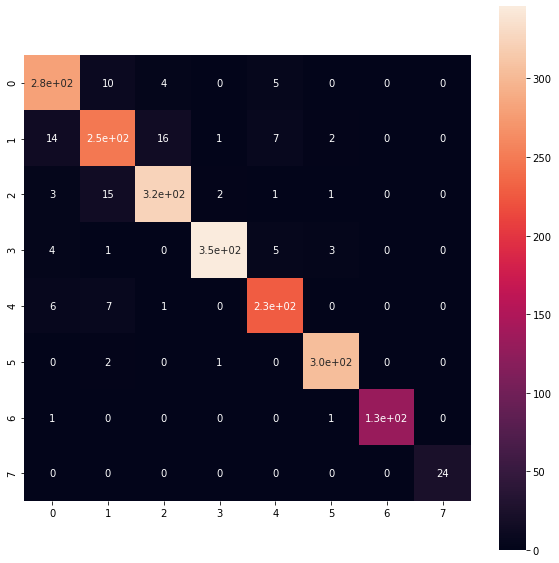

ACCURACY: 0.9435


In [10]:
# dataset_test = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_train.tfrecord'))
# def preprocess_dataset(dataset, batch_size):    
#     dataset = dataset.map(delete_y2)
#     dataset = dataset.map(to_rgb)
#     dataset = dataset.map(rescale_image)
#     dataset = dataset.map(to_classes)
#     dataset = dataset.batch(batch_size)
#     return dataset

# dataset_test = preprocess_dataset(dataset_test, 1)
# tru_y = []
# for x, y in dataset_test.take(2000):
#     tru_y.append(y.numpy()[0])
# pred_y = model.predict(dataset_test.take(2000))
# b = np.zeros_like(pred_y)
# b[np.arange(len(pred_y)), pred_y.argmax(1)] = 1
# testing_dataframe = pd.DataFrame({'tru':np.array(tru_y).argmax(1), 'pred':b.argmax(1)})
# testing_dataframe['error'] = np.abs(testing_dataframe['tru'] - testing_dataframe['pred'])

# # bins = [0, 0.2, 0.4, 0.6, 1]
# # labels = ['young', 'young_Adult', 'Adult', 'senior']
# # testing_dataframe['tru'] = pd.cut(testing_dataframe['tru'], bins=bins, labels=labels)
# # testing_dataframe['pred'] = pd.cut(testing_dataframe['pred'], bins=bins, labels=labels)
# # testing_dataframe = testing_dataframe.dropna()

# labels = [0, 1, 2, 3, 4, 5, 6, 7]
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(testing_dataframe.tru, testing_dataframe.pred)
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(cm, annot=True, square=True, xticklabels=labels, yticklabels=labels, ax=ax)
# plt.show()

# from sklearn.metrics import accuracy_score
# print('ACCURACY:', accuracy_score(testing_dataframe.tru, testing_dataframe.pred, normalize=True))

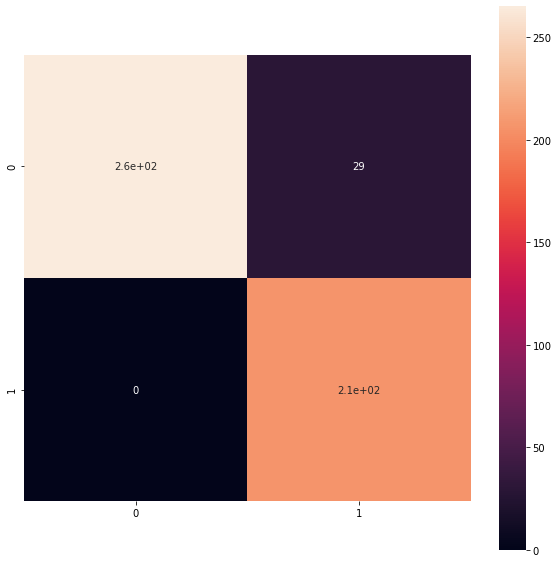

ACCURACY: 0.942


In [8]:
dataset_test = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_train.tfrecord'))
def preprocess_dataset(dataset, batch_size):    
    dataset = dataset.map(delete_y2)
    dataset = dataset.map(to_rgb)
    dataset = dataset.map(rescale_image)
    dataset = dataset.map(to_classes)
    dataset = dataset.batch(batch_size)
    return dataset

dataset_test = preprocess_dataset(dataset_test, 1)
tru_y = []
for x, y in dataset_test.take(500):
    tru_y.append(y.numpy()[0])
pred_y = model.predict(dataset_test.take(500))
b = np.zeros_like(pred_y)
b[np.arange(len(pred_y)), pred_y.argmax(1)] = 1
testing_dataframe = pd.DataFrame({'tru':np.array(tru_y).argmax(1), 'pred':b.argmax(1)})
testing_dataframe['error'] = np.abs(testing_dataframe['tru'] - testing_dataframe['pred'])

# bins = [0, 0.2, 0.4, 0.6, 1]
# labels = ['young', 'young_Adult', 'Adult', 'senior']
# testing_dataframe['tru'] = pd.cut(testing_dataframe['tru'], bins=bins, labels=labels)
# testing_dataframe['pred'] = pd.cut(testing_dataframe['pred'], bins=bins, labels=labels)
# testing_dataframe = testing_dataframe.dropna()

labels = [0, 1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_dataframe.tru, testing_dataframe.pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

from sklearn.metrics import accuracy_score
print('ACCURACY:', accuracy_score(testing_dataframe.tru, testing_dataframe.pred, normalize=True))